# Tutorial for fine-Tuning ChromBERT from scratch

Welcome to our tutorial on fine-tuning ChromBERT from scratch! In this guide, we will walk you through the process of predicting CTCF peaks (ENCFF664UGR).

**Please note:** This tutorial serves as a simple demonstration. For comprehensive guidance and productive usage, please refer to our complete documentation: [Tutorials](https://chrombert.readthedocs.io/en/latest/finetune.html).

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # set the GPU to use
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python" # for compatibility of tensorboard

import torch 
import pathlib 

import chrombert 
from tqdm import tqdm
import numpy as np
import pandas as pd 
from umap import UMAP

import seaborn as sns
from matplotlib import pyplot as plt

from torchinfo import summary

basedir = os.path.expanduser("~/.cache/chrombert/data")


/home/yangdongxu/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Dataset Preparation

In this section, we will guide you through the process of preparing the dataset for fine-tuning ChromBERT. 

Steps to Prepare the Dataset:

1. Prepare Regions and Labels: Start by identifying the genomic regions and their corresponding labels that you want to use for fine-tuning.

2. Align to Human-Cistrome-6k: Align your regions to the Human-Cistrome-6k dataset using genomic coordinates to ensure consistency and accuracy.

3. Create a Dataset Configuration: Develop a configuration file that specifies the details of your dataset, including paths and parameters.

4. Generate the Dataset Object: Finally, use the configuration to create a dataset object that can be utilized in the fine-tuning process.

By following these steps, you will have a properly prepared dataset ready for ChromBERT fine-tuning.

In [2]:
from chrombert.scripts.chrombert_make_dataset import get_overlap

df_supervised = get_overlap(
    supervised = os.path.join(basedir, "demo", "embedding","CTCF_ENCFF664UGR.bed"), # a narrowPeak file
    regions = os.path.join(basedir, "config", "hg38_6k_1kb_region.bed"),
    no_filter = True,
).assign(label = lambda df: df["label"] > 0 )
df_supervised

,chrom,start,end,build_region_index,label
0,chr1,10000,11000,0,False
1,chr1,16000,17000,1,False
2,chr1,17000,18000,2,False
3,chr1,29000,30000,3,False
4,chr1,30000,31000,4,False
...,...,...,...,...,...
2137889,chrY,26671000,26672000,2137889,False
2137890,chrY,56674000,56675000,2137890,False
2137891,chrY,56678000,56679000,2137891,False
2137892,chrY,56684000,56685000,2137892,False


Since this is a simple demonstration, we will use only **chr21** for training and **chr22** for evaluation. 

In [3]:
from sklearn.model_selection import train_test_split
df_supervised = df_supervised.groupby("label").sample(50000, random_state=42) # downsample to generate a balanced dataset. For real applications, you may want to use the full dataset. 
df_chr21 = df_supervised.query("chrom == 'chr21'").reset_index(drop=True)
df_train, df_valid = train_test_split(df_chr21, test_size=0.2, random_state=42)
df_test = df_supervised.query("chrom == 'chr22'").reset_index(drop=True)

odir = pathlib.Path("tmp_ft")
odir.mkdir(exist_ok=True)
df_train.to_csv(odir/"train.csv", index=False)
df_valid.to_csv(odir/"valid.csv", index=False)
df_test.to_csv(odir/"test.csv", index=False)
len(df_train), len(df_valid), len(df_test)

(889, 223, 1922)

We offer the `chrombert.get_preset_dataset_config` interface to simplify the creation of your dataset configuration. This function provides a quick and easy way to set up your dataset for fine-tuning.

For more advanced usage, you can create a custom dataset configuration using the `chrombert.DatasetConfig` class. This allows for greater flexibility and customization to meet your specific requirements.

In [4]:
dc = chrombert.get_preset_dataset_config(
    "general", 
    supervised_file = str(odir/"train.csv"), # convert to str dtype
    batch_size=4
    )
ds = dc.init_dataset() # initialize the dataset from config 
ds[1]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


{'input_ids': tensor([8, 6, 8,  ..., 9, 6, 6], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([      21, 39126000, 39127000], dtype=torch.int32),
 'build_region_index': 1169028,
 'label': True}

We utilize PyTorch Lightning to facilitate the training of the model. As part of this process, the dataset is wrapped in a `lightning.pytorch.core.LightningDataModule`. This encapsulation provides a structured way to handle data loading and preprocessing, making it easier to manage the training workflow.

In [5]:
data_module = chrombert.LitChromBERTFTDataModule(
    config = dc,
    train_params = dict(supervised_file = str(odir/"train.csv")),
    val_params = dict(supervised_file = str(odir/"valid.csv")),
    test_params = dict(supervised_file = str(odir/"test.csv")),
)
data_module

## Model Configuration

To simplify the creation of your model configuration, we provide the `chrombert.get_preset_model_config` interface. This function allows you to quickly set up a model configuration for fine-tuning ChromBERT.

For users seeking more advanced customization, you can create your own model configuration using the `chrombert.ChromBERTFTConfig` class. This gives you the flexibility to tailor the model parameters to better suit your specific needs and objectives.

In [6]:
mc = chrombert.get_preset_model_config("general")
print(mc)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
{
    "genome": "hg38",
    "task": "general",
    "dim_output": 1,
    "mtx_mask": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_mask_matrix.tsv",
    "dropout": 0.1,
    "pretrain_ckpt": "/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_pretrain.ckpt",
    "finetune_ckpt": null,
    "ignore": false,
    "ignore_index": [
        null,
        null
    ],
    "gep_flank_window": 4,
    "gep_parallel_embedding": false,
    "gep_gradient_checkpoint": false,
    "gep_zero_inflation": true,
    "prompt_kind": "cistrome",
    "prompt_dim_external": 512,
    "dnabert2_ckpt": null
}


In [7]:
model = mc.init_model()
model

use organisim hg38; max sequence length including cls is 6392


ChromBERTGeneral(
  (pretrain_model): ChromBERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(10, 768, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): PositionalEmbeddingTrainable(
          (pe): Embedding(6392, 768)
        )
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0-7): 8 x EncoderTransformerBlock(
        (attention): SelfAttentionFlashMHA(
          (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=768, out_features=3072, bias=True)
          (w_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation): GELU()
        )
        (input_sublayer): SublayerConnection(
          (norm): LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output_sublayer): SublayerConnection(
 

## Fine-Tuning

We leverage PyTorch Lightning to train the model, providing a straightforward interface for implementing the training loop. This approach streamlines the training process, making it easier to manage and customize various aspects of model training, such as callbacks, logging, and checkpointing.  You can also implement custom training logic.

In [8]:
tc = chrombert.finetune.TrainConfig(
    kind = "classification",
    loss = "bce", # use bce loss here
    max_epochs=3,
    val_check_interval=0.2,
    )
trainer = tc.init_trainer( # prepare pytorch lightning trainer
    precision = "bf16-mixed", # use bfloat16 to speed up training
    save_top_k = 3 # save the top 3 models. metrics can be set by `checkpoint_metric` and `checkpoint_mode`
    ) 
print(tc)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{
    "kind": "classification",
    "loss": "bce",
    "tag": "default",
    "adam_beta1": 0.9,
    "adam_beta2": 0.999,
    "weight_decay": 0.01,
    "lr": 0.0001,
    "warmup_ratio": 0.1,
    "max_epochs": 3,
    "gradient_accumulation_steps": 1,
    "accumulate_grad_batches": 1,
    "limit_val_batches": 64,
    "val_check_interval": 0.2,
    "checkpoint_metric": "bce",
    "checkpoint_mode": "min"
}


In [9]:
pl_module = tc.init_pl_module(model) # wrap the model into a pytorch lightning module
summary(pl_module)

Layer (type:depth-idx)                                       Param #
ClassificationPLModule                                       --
├─ChromBERTGeneral: 1-1                                      --
│    └─ChromBERT: 2-1                                        --
│    │    └─BERTEmbedding: 3-1                               4,916,736
│    │    └─ModuleList: 3-2                                  51,978,240
│    └─GeneralHeader: 2-2                                    --
│    │    └─CistromeEmbeddingManager: 3-3                    --
│    │    └─Conv2d: 3-4                                      769
│    │    └─ReLU: 3-5                                        --
│    │    └─ResidualBlock: 3-6                               3,232,768
│    │    └─ResidualBlock: 3-7                               2,166,528
│    │    └─ResidualBlock: 3-8                               460,032
│    │    └─Linear: 3-9                                      257
Total params: 62,755,330
Trainable params: 62,755,330
Non-train

In [10]:
trainer.fit(pl_module, data_module) # start training, it takes nearly 10 minutes on a single A100 GPU

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params
-------------------------------------------
0 | model | ChromBERTGeneral | 62.8 M
-------------------------------------------
62.8 M    Trainable params
0         Non-trainable params
62.8 M    Total params
251.021   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/miniconda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 44: 'default_validation/bce' reached 0.40430 (best 0.40430), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=44.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 88: 'default_validation/bce' reached 0.22804 (best 0.22804), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=88.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 132: 'default_validation/bce' reached 0.21750 (best 0.21750), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=132.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 176: 'default_validation/bce' reached 0.18001 (best 0.18001), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=0-step=176.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 0, global step 220: 'default_validation/bce' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 267: 'default_validation/bce' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 311: 'default_validation/bce' reached 0.19854 (best 0.18001), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=311.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 355: 'default_validation/bce' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 399: 'default_validation/bce' reached 0.17850 (best 0.17850), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=399.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 443: 'default_validation/bce' reached 0.16531 (best 0.16531), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=443.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 490: 'default_validation/bce' reached 0.16222 (best 0.16222), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=2-step=490.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 534: 'default_validation/bce' reached 0.17444 (best 0.16222), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/epoch=2-step=534.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 578: 'default_validation/bce' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 622: 'default_validation/bce' was not in top 3


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 666: 'default_validation/bce' was not in top 3
`Trainer.fit` stopped: `max_epochs=3` reached.


Checkpoints will be saved in `lightning_logs/chrombert-ft` by default. 

In [11]:
path = pathlib.Path("lightning_logs/chrombert-ft")
for p in path.rglob("*ckpt"):
    if "last.ckpt" in str(p):
        path_last_ckpt = p
    print(p)

lightning_logs/chrombert-ft/version_0/checkpoints/last.ckpt
lightning_logs/chrombert-ft/version_0/checkpoints/epoch=1-step=443.ckpt
lightning_logs/chrombert-ft/version_0/checkpoints/epoch=2-step=490.ckpt
lightning_logs/chrombert-ft/version_0/checkpoints/epoch=2-step=534.ckpt


## Evaluation

In this section, we will evaluate the performance of the fine-tuned model. This evaluation is crucial for understanding how well the model has learned from the training data and how effectively it can predict CTCF peaks on unseen data. 


In [12]:
# load test dataset
dc = chrombert.get_preset_dataset_config(
    "general", 
    supervised_file = str(odir/"test.csv"), # convert to str dtype
    batch_size=4
    )
ds = dc.init_dataset()
ds[1]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json


{'input_ids': tensor([5, 5, 5,  ..., 6, 5, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([      22, 32679000, 32680000], dtype=torch.int32),
 'build_region_index': 1189560,
 'label': False}

In [13]:
# load model from checkpoint
mc = chrombert.get_preset_model_config(
    "general", 
    finetune_ckpt = os.path.abspath(str(path_last_ckpt)), # setting checkpoint path, must use absolute path
    dropout = 0 # to avoid randomness 
)
model = mc.init_model().cuda().bfloat16().eval()
summary(model)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = /home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/last.ckpt
use organisim hg38; max sequence length including cls is 6392
Loading checkpoint from /home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_0/checkpoints/last.ckpt
Loading from pl module, remove prefix 'model.'
Loaded 110/110 parameters


Layer (type:depth-idx)                                  Param #
ChromBERTGeneral                                        --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

In [14]:
# forward 
list_logit = []
list_label = []
dl = dc.init_dataloader()
with torch.no_grad():
    for i, batch in tqdm(enumerate(dl), total = len(dl)):
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.cuda()
        output = model(batch)
        list_logit.append(output.float().cpu().numpy()) # must convert to float before converting to cpu
        list_label.append(batch["label"].cpu().numpy())

list_logit = np.concatenate(list_logit, axis=0).reshape(-1)
list_label = np.concatenate(list_label, axis=0).reshape(-1)
df_prob = pd.DataFrame(
    dict(
        logit = list_logit,
        label = list_label
    )
)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

df_prob["prob"] = sigmoid(df_prob["logit"])
df_prob


100%|██████████| 481/481 [01:14<00:00,  6.48it/s]


,logit,label,prob
0,-6.562500,False,0.001410
1,-7.000000,False,0.000911
2,-4.875000,False,0.007577
3,-4.531250,False,0.010653
4,-3.328125,False,0.034619
...,...,...,...
1917,3.453125,True,0.969324
1918,3.859375,True,0.979354
1919,3.984375,True,0.981736
1920,4.468750,True,0.988668


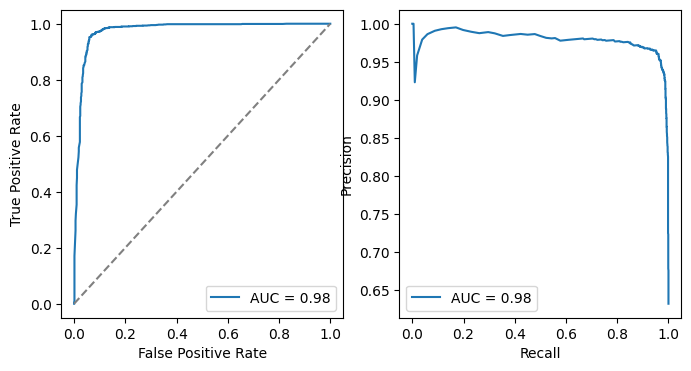

In [15]:
from sklearn import metrics
# plot the ROC curve and PRC curve
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fpr, tpr, _ = metrics.roc_curve(df_prob["label"], df_prob["prob"])
ax[0].plot(fpr, tpr, label=f"AUC = {metrics.auc(fpr, tpr):.2f}")
ax[0].plot([0, 1], [0, 1], "--", color="gray")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()
precision, recall, _ = metrics.precision_recall_curve(df_prob["label"], df_prob["prob"])
ax[1].plot(recall, precision, label=f"AUC = {metrics.auc(recall, precision):.2f}")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()
plt.show()


## The End

That's it! You've reached the end of this tutorial. The steps outlined here can be applied to other tasks as well, as they generally follow a similar process. For more detailed information on specific tasks, please refer to the corresponding tutorials available.

Thank you for using ChromBERT! We appreciate your interest and hope you find this tool valuable for your research. If you have any questions or need further assistance, feel free to reach out!